In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('thirdparty/')
import numpy as np
from colmap.scripts.python.read_write_model import (read_model,
                                                    qvec2rotmat,
                                                    read_cameras_text,
                                                    read_images_text,
                                                    read_points3D_text)
from colmap.scripts.python.read_dense import read_array
from imageio import imread, imsave
from os import makedirs
from os.path import isdir, isfile
from tqdm import tqdm
from skimage.transform import resize as imresize
import h5py
from multiprocessing import Pool, cpu_count
from argparse import ArgumentParser
from IPython import embed
from time import time, sleep
from scipy.spatial import KDTree
import OpenEXR as exr
import Imath
from copy import deepcopy

def read_depth_image(fname):
    exrfile = exr.InputFile(fname)
    header = exrfile.header()
    dw = header['dataWindow']
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
    channelData = dict()
    # convert all channels in the image to numpy arrays
    for c in header['channels']:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        C = np.fromstring(C, dtype=np.float32)
        C = np.reshape(C, isize)
        channelData[c] = C
    d = deepcopy(channelData['Z'])
    d[d>1e10] = 0
    return d

def read_colmap_txt(dir_name):
    cameras = read_cameras_text(os.path.join(dir_name, 'cameras.txt'))
    images = read_images_text(os.path.join(dir_name, 'images.txt'))
    points = read_points3D_text(os.path.join(dir_name, 'points3D.txt'))
    return  cameras, images, points
    
                                
    

def parse_image(args):
    cur_camera, cur_image, points, src, n, th = args[0], args[1], args[2], args[3], args[4], args[5]

    output = src + '/dense/stereo/depth_maps_clean_{:d}_th_{:.2f}'.format(n, th)
    if not os.path.isdir(output):
        os.makedirs(output)
    fn = output + '/' + '.'.join(cur_image.name.split('.')[:-1])

    if isfile(fn + '.h5') and isfile(fn + '.jpg'):
        print(f'Current file: "{cur_image.name}". Done, skipping!')
        return True
    else:
        print(f'Current file: "{cur_image.name}". Processing...')

    image = imread(src + '/dense/images/' + cur_image.name)

    # Some depth files do not exist?
    in_fname=f'{src}/depth_masks/{cur_image.name}.depth.exr'
    if isfile(in_fname):
        try:
            depth = read_depth_image(in_fname)
        except:
            return False
    else:
        return False

    # min_depth, max_depth = np.percentile(depth, [5, 95])
    # depth[depth < min_depth] = min_depth
    # depth[depth > max_depth] = max_depth

    # with regular spacing (n is the largest dim)
    if depth.shape[0] > depth.shape[1]:
        nx, ny = int(np.round(n * depth.shape[1] / depth.shape[0])), n
    else:
        nx, ny = n, int(np.round(n * depth.shape[0] / depth.shape[1]))
    # print(f'Processing image "{cur_image.name}" (grid size: {nx}x{ny})')

    q = cur_image.qvec
    R = qvec2rotmat(q)
    T = cur_image.tvec
    p = cur_image.xys
    pars = cur_camera.params
    K = np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])
    pids = cur_image.point3D_ids
    v = pids >= 0
    # print('Number of points: {}'.format((pids > -1).sum()))

    # make a 3d grid
    xg, yg = np.meshgrid(np.linspace(0, depth.shape[1] - 1, nx), np.linspace(0, depth.shape[0] - 1, ny))
    xg, yg = np.round(xg).astype(int), np.round(yg).astype(int)
    x_c = np.concatenate((xg.flatten()[..., None], yg.flatten()[..., None], np.ones((xg.size, 1))), axis=1)
    d = depth[yg.flatten(), xg.flatten()]

    # move the grid on top of the reconstruction
    x_w = np.dot(np.linalg.inv(K), x_c.T)
    x_w = x_w * d / x_w[2, :]
    x_w = np.dot(R.T, x_w - T[..., None])

    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    x2, y2, z2 = x_w[0, :], x_w[1, :], x_w[2, :]

    # clean up the projected depth map
    valid = []
    min_d = np.zeros(nx * ny)
    tree = KDTree(points)
    min_dist = (tree.query(x_w.T, 1)[0]).reshape(-1)
    valid_pts = min_dist < th
    valid = np.flatnonzero(valid_pts)
    #for i, p in enumerate(x_w.T):
        # if i % 5000 == 0:
        #     print(f'At {i+1}/{x_w.shape[1]}')
        # d = np.linalg.norm(points - p, axis=1)
        # min_d[i] = d.min()
    #    min_d[i] = tree.query(p, 1)[0]
    #    if min_d[i] < th:
    #        valid.append(i)
    #print (valid)
    print(f'Valid points: {len(valid)}/{x_w.shape[1]}')

    # Save the minimum distance to the model in case we want to recompute the depth maps
    # (Thresholding is a bit iffy...)
    min_d_resized = imresize(min_d.reshape((ny, nx)), depth.shape, order=0)

    # Clean up depth map
    d_clean = np.zeros(nx * ny)
    d_clean[valid] = depth[yg.flatten()[valid], xg.flatten()[valid]]

    # You still get d < 0 (due to points landing near the model by chance?)
    d_clean[d_clean < 0] = 0

    d_clean = d_clean.reshape((ny, nx))
    d_resized = imresize(d_clean, depth.shape, order=0)

    with h5py.File(fn + '.h5', 'w') as f:
        f['depth'] = d_resized.astype(np.float16)
        f['min_distance'] = min_d_resized.astype(np.float16)

    # Draw always with full range
    # gray = (d_resized - d_resized[d_resized > 0].min()) / (d_resized.max() - d_resized[d_resized > 0].min())
    try:
        gray = (d_resized.max() - d_resized) / (d_resized.max() - d_resized[d_resized > 0].min() + 1e-5)
    except:
        print ("Warning, no gray")
        return False
    rgb = gray[None, ...].repeat(3, axis=0)
    rgb[0][d_resized == 0] = 1
    rgb[1][d_resized == 0] = 0
    rgb[2][d_resized == 0] = 0

    # Sometimes the image is one pixel off??? Terrible
    if image.shape[:2] != depth.shape:
        image = np.round(imresize(image, depth.shape, order=1) * 255).astype(np.uint8)

    imsave(fn + '.jpg', np.concatenate(
        (image, np.round(255 * rgb.transpose((1, 2, 0))).astype(np.uint8)),
        axis=1))

    return True


In [2]:
parser = ArgumentParser()
parser.add_argument("--seq", type=str)
parser.add_argument("--n", type=int, default=300)
parser.add_argument("--th", type=float, default=0.1)
parser.add_argument("--poolsize", type=int, default=8)
params = parser.parse_args(args=[])

root = '/home/old-ufo/datasets/tree/'
# seq = 'florence_cathedral_side'

#seqs = params.seq.split(',')
seqs = ['tree_in_colmap']


In [3]:
seq=seqs[0]
n = 200
th = 0.5

In [4]:
t = time()
src = root + '/' + seq
output = src + '/dense/stereo/depth_maps_clean_{:d}_th_{:.2f}'.format(n, th)
if not isdir(output):
    makedirs(output)

# Parse reconstruction
print(f'Processing: "{seq}"')
cameras, images, points = read_colmap_txt(os.path.join(src,'reconstruction'))
print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')
indices = [i for i in cameras]

# Get 3d points
xyz, rgb = [], []
for i in points:
    xyz.append(points[i].xyz)
    rgb.append(points[i].rgb)
xyz = np.array(xyz)
rgb = np.array(rgb)

args = []
for index in indices:
    args.append((cameras[index], images[index], xyz, src, n, th))


Processing: "tree_in_colmap"
Cameras: 1049
Images: 1049
3D points: 962726


In [43]:
tttt1 = time()
cur_camera, cur_image, points, src, n, th = args[0][0], args[0][1], args[0][2], args[0][3], args[0][4], args[0][5]
output = src + '/dense/stereo/depth_maps_clean_{:d}_th_{:.2f}'.format(n, th)
if not os.path.isdir(output):
    os.makedirs(output)
fn = output + '/' + '.'.join(cur_image.name.split('.')[:-1])

if isfile(fn + '.h5') and isfile(fn + '.jpg'):
    print(f'Current file: "{cur_image.name}". Done, skipping!')
    #return True
else:
    print(f'Current file: "{cur_image.name}". Processing...')

image = imread(src + '/dense/images/' + cur_image.name)

# Some depth files do not exist?
in_fname=f'{src}/depth_masks/{cur_image.name}.depth.exr'
if isfile(in_fname):
    try:
        depth = read_depth_image(in_fname)
    except:
        print ("Cannot read depth")
#        return False
else:
    print ("No read depth")
#    return False

# min_depth, max_depth = np.percentile(depth, [5, 95])
# depth[depth < min_depth] = min_depth
# depth[depth > max_depth] = max_depth

# with regular spacing (n is the largest dim)
if depth.shape[0] > depth.shape[1]:
    nx, ny = int(np.round(n * depth.shape[1] / depth.shape[0])), n
else:
    nx, ny = n, int(np.round(n * depth.shape[0] / depth.shape[1]))
# print(f'Processing image "{cur_image.name}" (grid size: {nx}x{ny})')

q = cur_image.qvec
R = qvec2rotmat(q)
T = cur_image.tvec
p = cur_image.xys
pars = cur_camera.params
K = np.array([[pars[0], 0, pars[1]], [0, pars[0], pars[2]], [0, 0, 1]])
#pids = cur_image.point3D_ids
#v = pids >= 0
# print('Number of points: {}'.format((pids > -1).sum()))

# make a 3d grid
xg, yg = np.meshgrid(np.linspace(0, depth.shape[1] - 1, nx), np.linspace(0, depth.shape[0] - 1, ny))
xg, yg = np.round(xg).astype(int), np.round(yg).astype(int)
x_c = np.concatenate((xg.flatten()[..., None], yg.flatten()[..., None], np.ones((xg.size, 1))), axis=1)
d = depth[yg.flatten(), xg.flatten()]

print (d_valid_mask.shape)
# move the grid on top of the reconstruction
x_w = np.dot(np.linalg.inv(K), x_c.T)
x_w = x_w * d / x_w[2, :]
x_w = np.dot(R.T, x_w - T[..., None])
#x_w = x_w[:,d_valid_mask]
#x_w = np.dot(R.T, x_w + T[..., None])

x, y, z = points[:, 0], points[:, 1], points[:, 2]
x2, y2, z2 = x_w[0, :], x_w[1, :], x_w[2, :]

# clean up the projected depth map
valid = []
min_d = np.zeros(nx * ny)
tttt=time()
tree = KDTree(points)
print ('kd tree contruction time = ', time() -tttt)
min_dist = (tree.query(x_w.T, 1, p=2)[0]).reshape(-1)
print (min_dist)
valid_pts = min_dist < th
valid = np.flatnonzero(valid_pts)
print (valid)
#for i, p in enumerate(x_w.T):
    # if i % 5000 == 0:
    #     print(f'At {i+1}/{x_w.shape[1]}')
    # d = np.linalg.norm(points - p, axis=1)
    # min_d[i] = d.min()
#    min_d[i] = tree.query(p, 1)[0]
#    if min_d[i] < th:
#        valid.append(i)
#print (valid)
print(f'Valid points: {len(valid)}/{x_w.shape[1]}')

# Save the minimum distance to the model in case we want to recompute the depth maps
# (Thresholding is a bit iffy...)
min_d_resized = imresize(min_d.reshape((ny, nx)), depth.shape, order=0)

# Clean up depth map
d_clean = np.zeros(nx * ny)
d_clean[valid] = depth[yg.flatten()[valid], xg.flatten()[valid]]

# You still get d < 0 (due to points landing near the model by chance?)
d_clean[d_clean < 0] = 0

d_clean = d_clean.reshape((ny, nx))
d_resized = imresize(d_clean, depth.shape, order=0)

with h5py.File(fn + '.h5', 'w') as f:
    f['depth'] = d_resized.astype(np.float16)
    f['min_distance'] = min_d_resized.astype(np.float16)

# Draw always with full range
# gray = (d_resized - d_resized[d_resized > 0].min()) / (d_resized.max() - d_resized[d_resized > 0].min())
try:
    gray = (d_resized.max() - d_resized) / (d_resized.max() - d_resized[d_resized > 0].min() + 1e-5)
except:
    print ("Warning, no gray")
    #return False
rgb = gray[None, ...].repeat(3, axis=0)
rgb[0][d_resized == 0] = 1
rgb[1][d_resized == 0] = 0
rgb[2][d_resized == 0] = 0

# Sometimes the image is one pixel off??? Terrible
if image.shape[:2] != depth.shape:
    image = np.round(imresize(image, depth.shape, order=1) * 255).astype(np.uint8)

imsave(fn + '.jpg', np.concatenate(
    (image, np.round(255 * rgb.transpose((1, 2, 0))).astype(np.uint8)),
    axis=1))
print ("total time = ", -tttt1 +time())

Current file: "IMG_9612.MOV_frame000001.png". Done, skipping!
(22600,)


/home/old-ufo/anaconda3/envs/fastai1/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


kd tree contruction time =  6.186729907989502
[1.64289348 1.64289348 1.64289348 ... 1.64289348 1.64289348 1.64289348]
[ 7083  7084  7085 ... 22364 22365 22366]
Valid points: 5394/22600
total time =  13.163594245910645


In [121]:
from copy import deepcopy
x_w2 = deepcopy(x_w)[::-1,:]
x_w2[0,:] = -x_w2[0,:]

In [122]:
min_dist3 = (tree.query(x_w2.T, 1)[0]).reshape(-1)


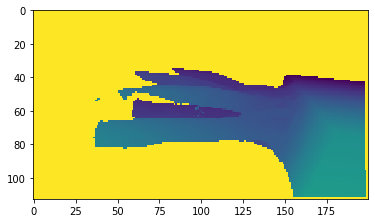

In [132]:
plt.imshow((x_w[2]).reshape(ny,nx))

{'channels': {'Z': FLOAT (1, 1)}, 'compression': ZIP_COMPRESSION, 'dataWindow': (0, 0) - (1919, 1087), 'displayWindow': (0, 0) - (1919, 1087), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 1.0}


64.47806

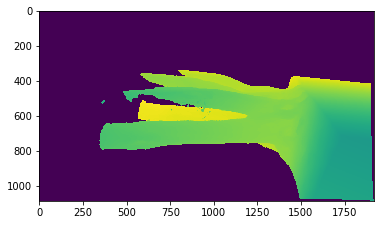

In [86]:
def read_depth_image2(fname):
    exrfile = exr.InputFile(fname)
    header = exrfile.header()
    dw = header['dataWindow']
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
    print (header)
    channelData = dict()
    # convert all channels in the image to numpy arrays
    for c in header['channels']:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        C = np.frombuffer(C, dtype=np.float32)
        C = np.reshape(C, isize)
        channelData[c] = C
    d = deepcopy(channelData['Z'])
    d[d>1e10] = 0
    return d
dept2 = read_depth_image2(in_fname)
plt.imshow((dept2))
dept2.max()

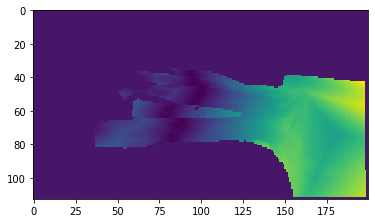

In [68]:
plt.imshow((min_dist).reshape(ny,nx))

In [41]:
from mpl_toolkits.mplot3d import Axes3D

In [49]:
import open3d as o3d

In [53]:
pcl = o3d.geometry.PointCloud(points=o3d.cuda.pybind.utility.Vector3dVector(points))

In [54]:
o3d.visualization.draw_geometries([pcl])